# Customer Churn Prediction

### Imports

In [87]:
# Tools
import pandas as pd
import numpy as np
import re
import random
import tensorflow as tf
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lifelines import KaplanMeierFitter, CoxPHFitter
from xgboost import XGBClassifier

# Visualisation
import matplotlib.pyplot as plt
from lime import lime_tabular
import math
import seaborn as sns

# Survival Analysis
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines import CoxPHFitter

### Loading Dataset

In [88]:
#adding the values in the csv file to a dataframe 'dataset' without Customer ID
dataset = pd.read_csv("../dataset/dataset.csv", usecols=lambda column: column!= 'customerID')

### Exploring Dataset

In [89]:
#checking the top 5 entries to get an idea
dataset.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [90]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


Total Charges is listed as an object while logically it should be a float variable.

In [91]:
#changing the datatype of Total Charges to numeric float
dataset["TotalCharges"] = pd.to_numeric(dataset["TotalCharges"], errors="coerce")

In [92]:
#correcting column names to make it readable
new_columns = [re.sub(r'(?<!^)([A-Z])', r' \1', col).title() for col in dataset.columns]
new_columns[-8] = 'Streaming TV'
dataset.columns = new_columns

In [93]:
#statistical values of the numerical data
dataset.describe()

,Senior Citizen,Tenure,Monthly Charges,Total Charges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [94]:
#now checking for null values
dataset.isna().sum()

Gender                0
Senior Citizen        0
Partner               0
Dependents            0
Tenure                0
Phone Service         0
Multiple Lines        0
Internet Service      0
Online Security       0
Online Backup         0
Device Protection     0
Tech Support          0
Streaming TV          0
Streaming Movies      0
Contract              0
Paperless Billing     0
Payment Method        0
Monthly Charges       0
Total Charges        11
Churn                 0
dtype: int64

In [95]:
# Seperating Categorical and Numerical columns
categorical_columns = dataset.select_dtypes(include=['object']).columns.tolist()
numerical_columns = [col for col in dataset.columns if col not in categorical_columns]

In [96]:
#checking the unique values in the dataset
for col in categorical_columns:
    print(f"{col} unique values : {dataset[col].unique()}")

Gender unique values : ['Female' 'Male']
Partner unique values : ['Yes' 'No']
Dependents unique values : ['No' 'Yes']
Phone Service unique values : ['No' 'Yes']
Multiple Lines unique values : ['No phone service' 'No' 'Yes']
Internet Service unique values : ['DSL' 'Fiber optic' 'No']
Online Security unique values : ['No' 'Yes' 'No internet service']
Online Backup unique values : ['Yes' 'No' 'No internet service']
Device Protection unique values : ['No' 'Yes' 'No internet service']
Tech Support unique values : ['No' 'Yes' 'No internet service']
Streaming TV unique values : ['No' 'Yes' 'No internet service']
Streaming Movies unique values : ['No' 'Yes' 'No internet service']
Contract unique values : ['Month-to-month' 'One year' 'Two year']
Paperless Billing unique values : ['Yes' 'No']
Payment Method unique values : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn unique values : ['No' 'Yes']


In [97]:
#the word automatic are not useful in the analysis
dataset["Payment Method"] = dataset["Payment Method"].str.replace(" (automatic)", "", regex=False)
dataset["Payment Method"].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'],
      dtype=object)

In [98]:
# Checking for Null Values
dataset.isna().sum()

Gender                0
Senior Citizen        0
Partner               0
Dependents            0
Tenure                0
Phone Service         0
Multiple Lines        0
Internet Service      0
Online Security       0
Online Backup         0
Device Protection     0
Tech Support          0
Streaming TV          0
Streaming Movies      0
Contract              0
Paperless Billing     0
Payment Method        0
Monthly Charges       0
Total Charges        11
Churn                 0
dtype: int64

In [99]:
#replacing specific column values to generalise
dataset['Multiple Lines'] = dataset['Multiple Lines'].replace(to_replace='No phone service', value='No service')
dataset.loc[:, ['Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']] = dataset.loc[:, ['Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']].replace(to_replace='No internet service', value='No service')

### Data Visualisation

In [100]:
# Setting Seaborn Theme Style
sns.set_theme(style='darkgrid')

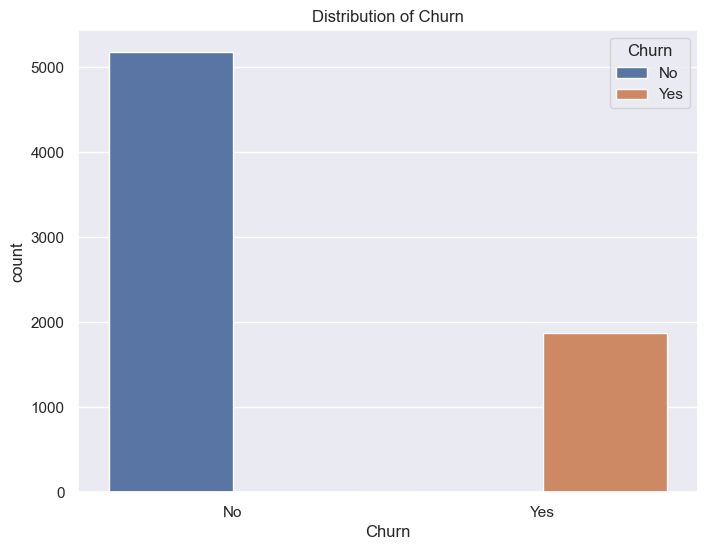

In [101]:
#plotting total churners vs non churners
plt.figure(figsize=(8, 6))
plt.title("Distribution of Churn")
sns.countplot(x = dataset["Churn"], hue=dataset["Churn"])
#plt.savefig("../Graphs/Churn Count")
plt.show()

In [102]:
#Make a function to plot categorical data according to target
def plot_categorical_to_target(dataset,categorical_values, target, title):
    number_of_columns = 2
    number_of_rows = math.ceil(len(categorical_values)/2)
    
    fig = plt.figure(figsize = (12, 5*number_of_rows))
    
    for index, column in enumerate(categorical_values, 1):
        ax = fig.add_subplot(number_of_rows,number_of_columns,index)
        ax = sns.countplot(x = column, data = dataset, hue = target)
    #plt.savefig(f"../Graphs/{title}")
    return plt.show()

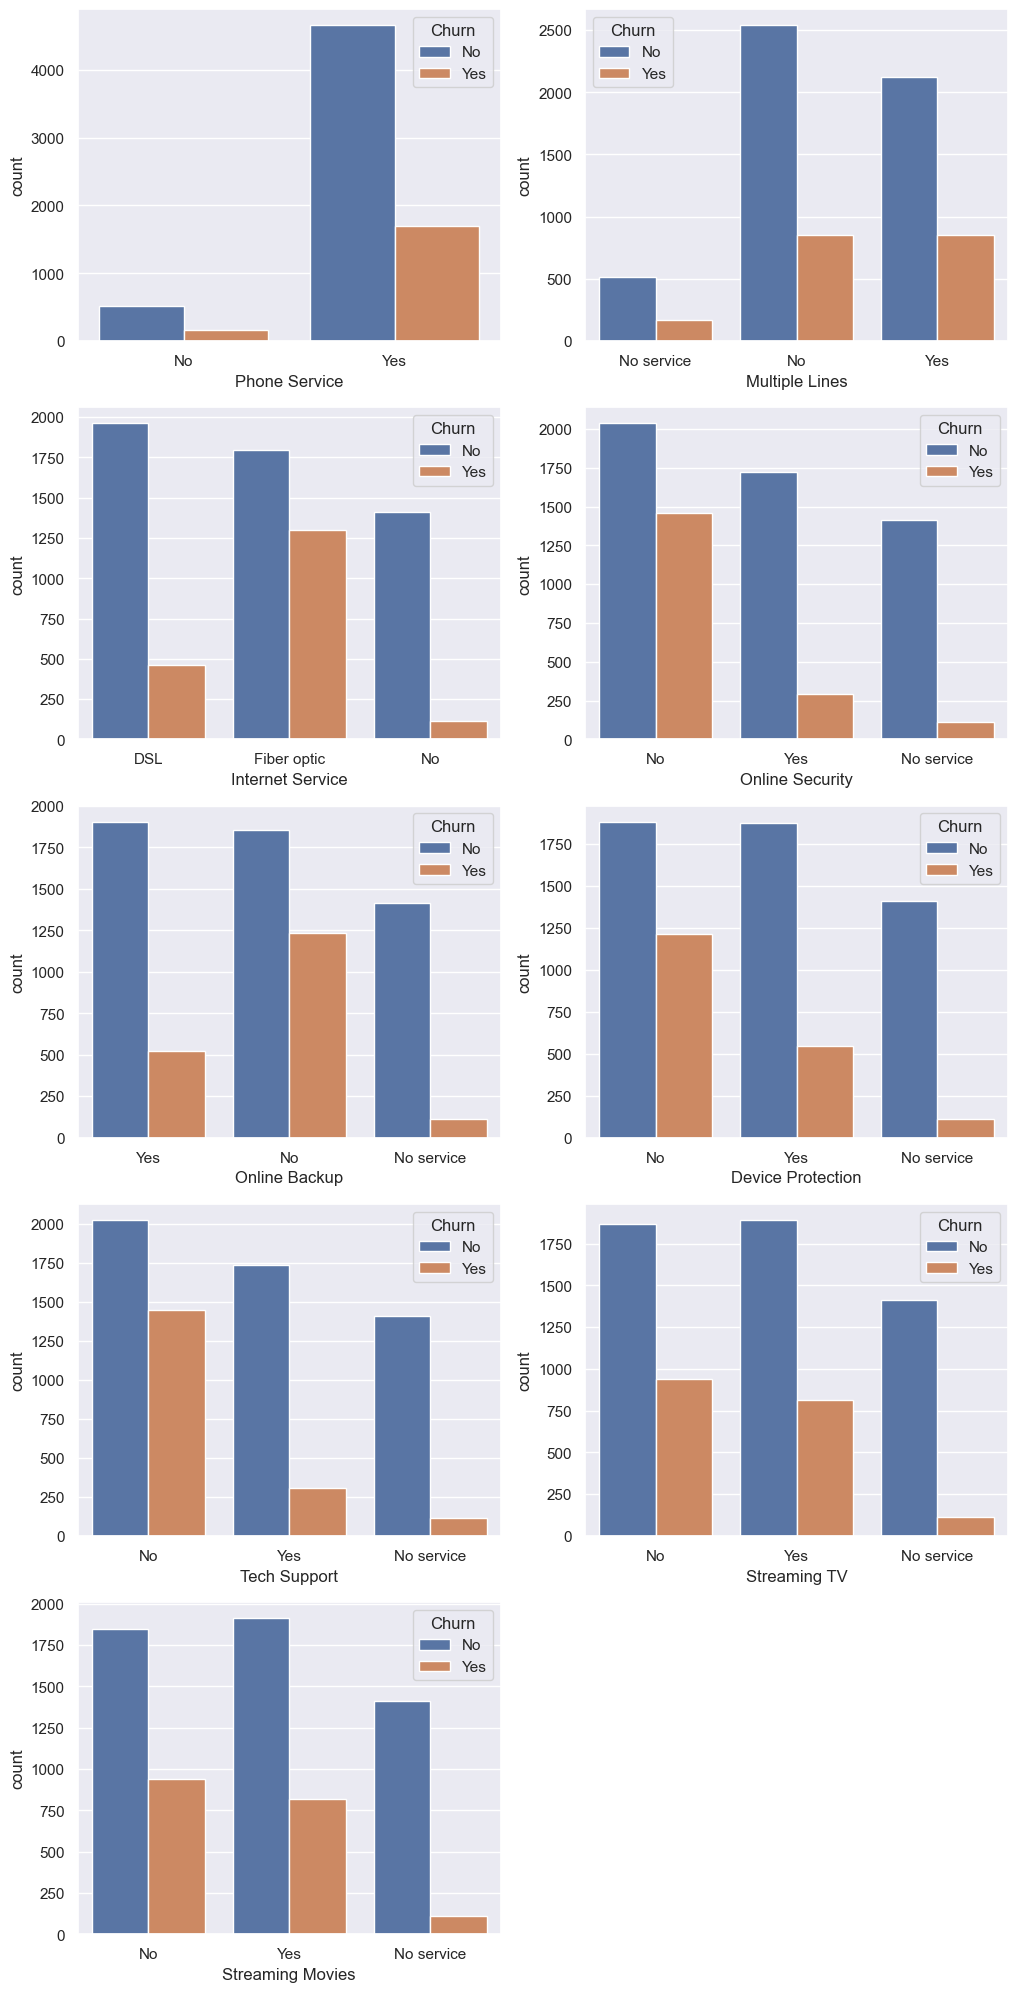

In [103]:
customer_services = ["Phone Service","Multiple Lines","Internet Service","Online Security","Online Backup",
                    "Device Protection","Tech Support","Streaming TV","Streaming Movies"]
plot_categorical_to_target(dataset,customer_services, "Churn", "Customer Service")

In [104]:
#mapping Senior Citizen column
ordinal_map = {
    1: 'Yes',
    0: 'No'
}
dataset['Senior Citizen'] = dataset['Senior Citizen'].map(ordinal_map)

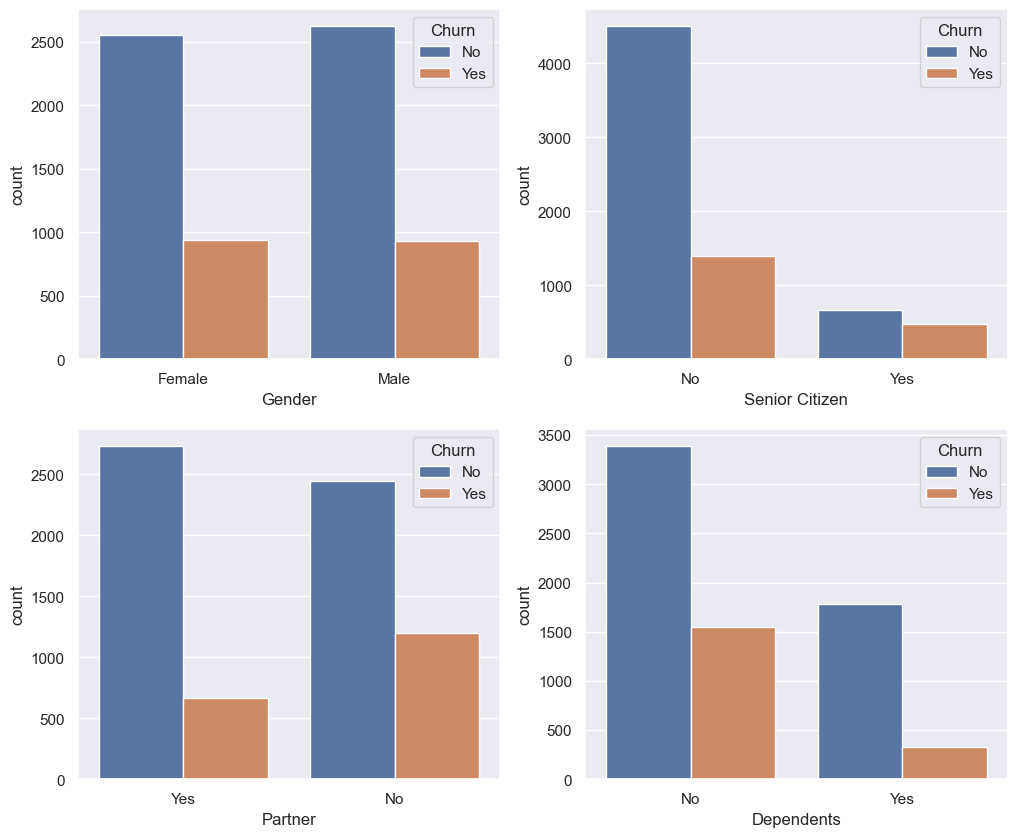

In [105]:
customer_account_cat = ["Gender","Senior Citizen","Partner","Dependents"]
plot_categorical_to_target(dataset,customer_account_cat,"Churn", "Demographic")

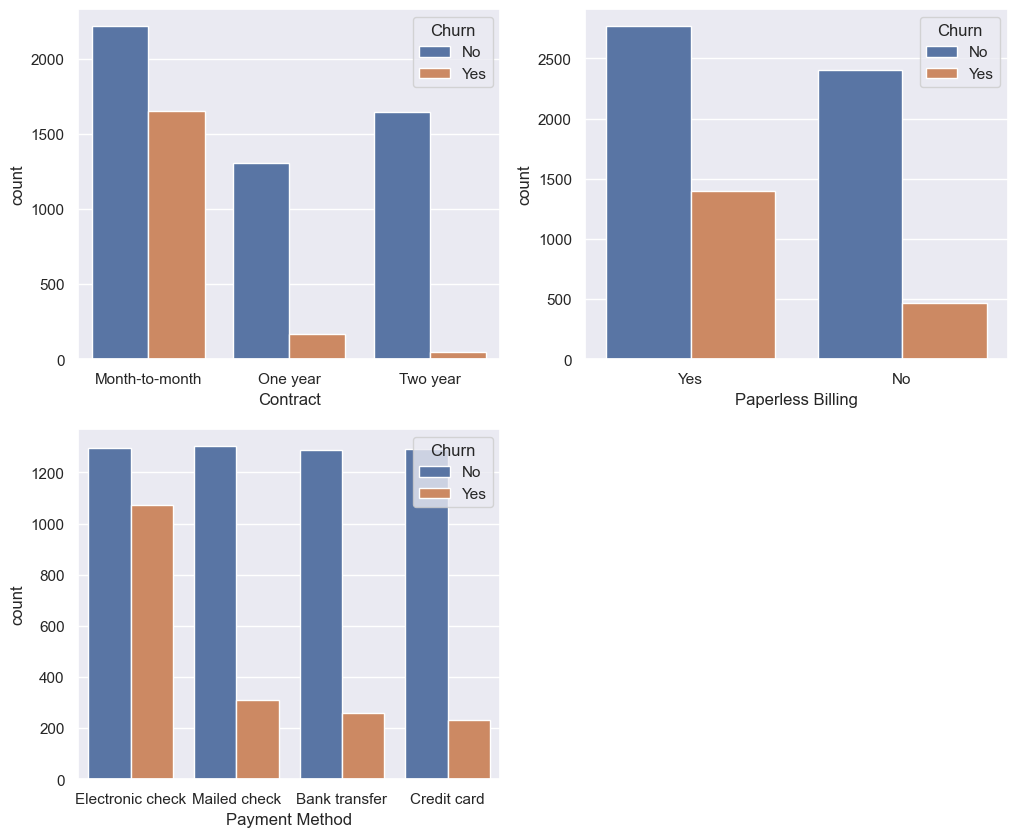

In [106]:
customer_account_cat = ["Contract","Paperless Billing","Payment Method"]
plot_categorical_to_target(dataset,customer_account_cat,"Churn", "Contract Type")

In [107]:
def KDE(dataset, numerical_values, target):
    number_of_columns = 2
    number_of_rows = math.ceil(len(numerical_values)/2)
    
    fig = plt.figure(figsize=(12,5*number_of_rows))
    
    for index, column in enumerate(numerical_values,1):
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)
        ax = sns.kdeplot(dataset[column][dataset[target]=="Yes"] ,fill = True)
        ax = sns.kdeplot(dataset[column][dataset[target]=="No"], fill = True)
        ax.legend(["Churn","No Churn"], loc='upper right')
    #plt.savefig("../Graphs/Charges")
    return plt.show()

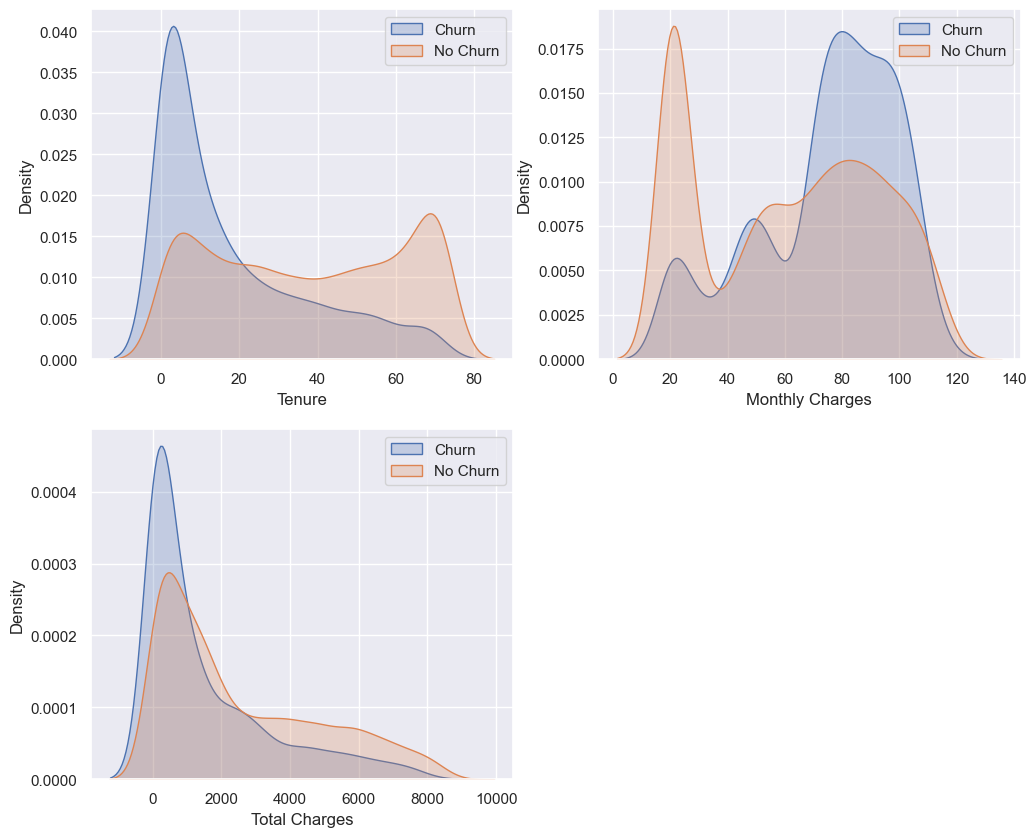

In [108]:
customer_account_num = ["Tenure", "Monthly Charges","Total Charges"]
KDE(dataset,customer_account_num, "Churn")

In [109]:
def outlier_check_boxplot(dataset,numerical_values,Target):
    number_of_columns = 2
    number_of_rows = math.ceil(len(numerical_values)/2)
    
    fig = plt.figure(figsize=(12,5*number_of_rows))
    for index, column in enumerate(numerical_values, 1):
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)
        ax = sns.boxplot(x = column, data = dataset, hue=Target)
    #plt.savefig("../Graphs/Boxplot Charges")
    return plt.show()

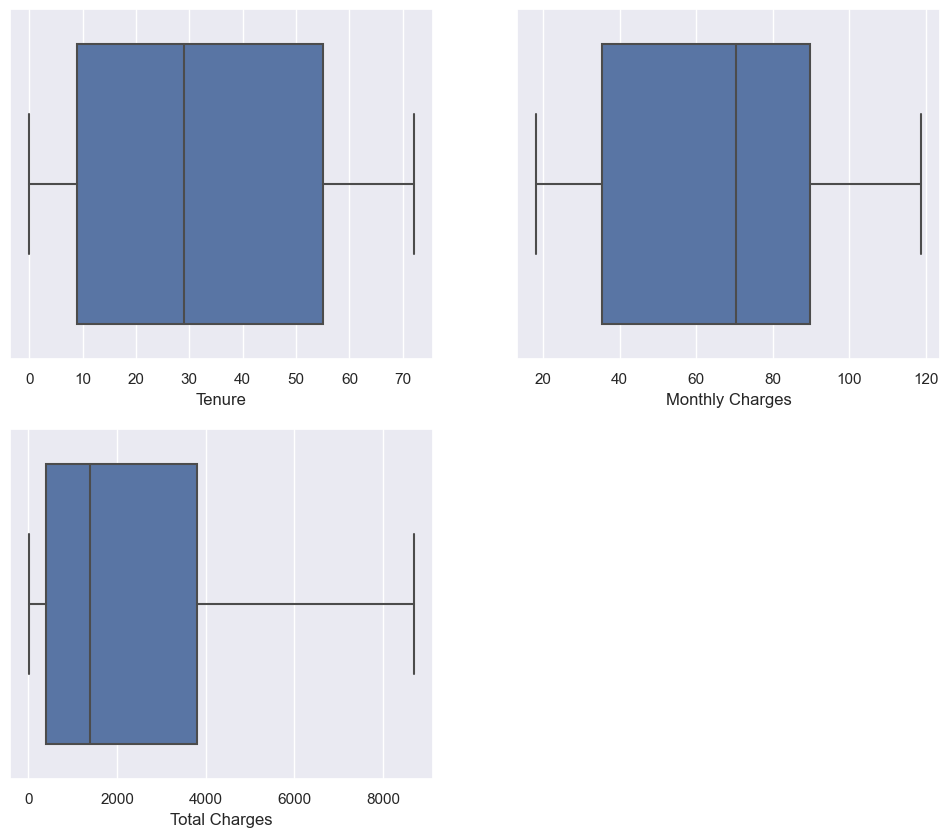

In [110]:
# Numerical Columns Distribution
numerical_values = ["Tenure","Monthly Charges","Total Charges"]
outlier_check_boxplot(dataset,numerical_values,"Churn")

### Ordinal Encoding

In [111]:
#seperating Categorical Columns based on Mapping Values
categorical_columns_ordinal_1 = [
    'Partner',
    'Dependents',
    'Phone Service',
    'Paperless Billing',
    'Churn'
]
categorical_columns_ordinal_2 = [
    'Multiple Lines',
    'Online Security',
    'Online Backup',
    'Device Protection',
    'Tech Support',
    'Streaming TV',
    'Streaming Movies'
]

In [112]:
#mapping Values
ordinal_map_1 = {
    'Yes': 1,
    'No': 0
}
ordinal_map_2 = {
    'Yes': 1,
    'No': 0,
    'No service': -1
}
ordinal_map_3 = {
    'Fiber optic': 1,
    'DSL': 0,
    'No': -1
}
ordinal_map_4 = {
    'Two year': 2,
    'One year': 1,
    'Month-to-month': 0
}
ordinal_map_5 = {
    'Female': 1,
    'Male': 0
}
ordinal_map_6 = {
    'Yes': 1,
    'No': 0
}

In [113]:
#mapping Values for Different Categorical Columns 
for col in categorical_columns_ordinal_1:
    dataset[col] = dataset[col].map(ordinal_map_1)

for col in categorical_columns_ordinal_2:
    dataset[col] = dataset[col].map(ordinal_map_2)

dataset['Internet Service'] = dataset['Internet Service'].map(ordinal_map_3)
dataset['Contract'] = dataset['Contract'].map(ordinal_map_4)
dataset['Gender'] = dataset['Gender'].map(ordinal_map_5)
dataset['Senior Citizen'] = dataset['Senior Citizen'].map(ordinal_map_6)

### Label Encoding 

In [114]:
#using Pandas Library to Encode Payment Method Column
dataset = pd.get_dummies(dataset, columns=['Payment Method'], drop_first=True)

In [115]:
#correcting column names for Payment Method
new_columns = list(dataset.columns)
new_columns[-1] = 'Payment Method(Mailed Check)'
new_columns[-2] = 'Payment Method(Electronic Check)'
new_columns[-3] = 'Payment Method(Mailed Credit Card)'
dataset.columns = new_columns

In [116]:
#changing datatype of Payment Method columns
for i in range(-1, -4, -1):
    dataset.iloc[:, i] = dataset.iloc[:, i].astype(int)

/var/folders/t2/0thdg7_d18g3k9kz17jgjl8r0000gn/T/ipykernel_58489/2825294462.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.iloc[:, i] = dataset.iloc[:, i].astype(int)


In [117]:
dataset

,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Monthly Charges,Total Charges,Churn,Payment Method(Mailed Credit Card),Payment Method(Electronic Check),Payment Method(Mailed Check)
0,1,0,1,0,1,0,-1,0,0,1,...,0,0,0,1,29.85,29.85,0,0,1,0
1,0,0,0,0,34,1,0,0,1,0,...,0,0,1,0,56.95,1889.50,0,0,0,1
2,0,0,0,0,2,1,0,0,1,1,...,0,0,0,1,53.85,108.15,1,0,0,1
3,0,0,0,0,45,0,-1,0,1,0,...,0,0,1,0,42.30,1840.75,0,0,0,0
4,1,0,0,0,2,1,0,1,0,0,...,0,0,0,1,70.70,151.65,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,1,1,24,1,1,0,1,0,...,1,1,1,1,84.80,1990.50,0,0,0,1
7039,1,0,1,1,72,1,1,1,0,1,...,1,1,1,1,103.20,7362.90,0,1,0,0
7040,1,0,1,1,11,0,-1,0,1,0,...,0,0,0,1,29.60,346.45,0,0,1,0
7041,0,1,1,0,4,1,1,1,0,0,...,0,0,0,1,74.40,306.60,1,0,0,1


### Correlation Heatmap

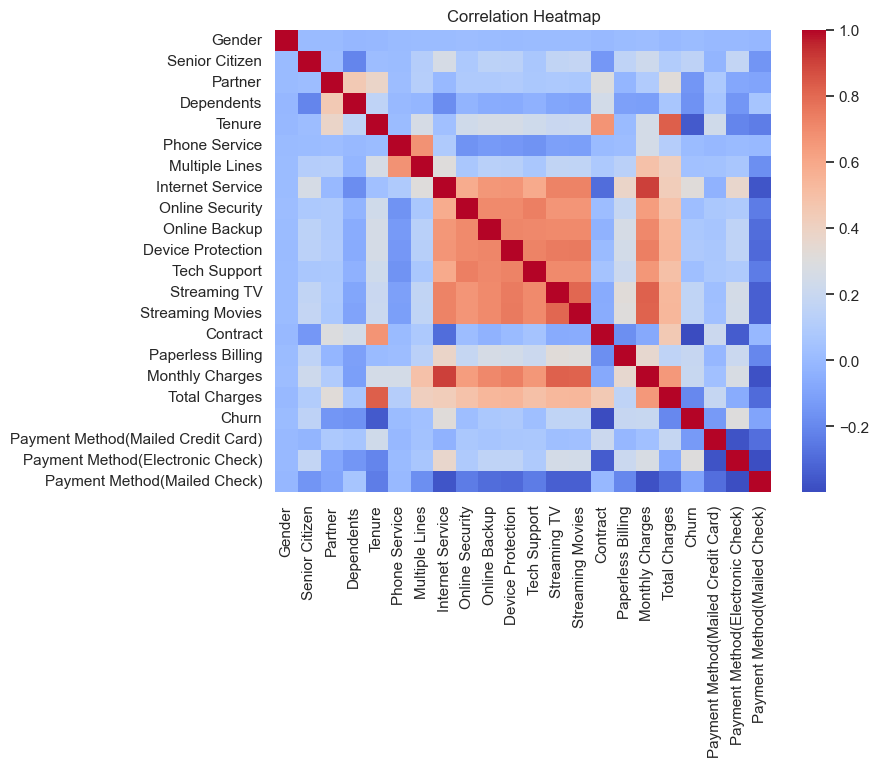

In [118]:
correrlation = dataset.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correrlation, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Churned Customers

In [119]:
dataset_churned = dataset[dataset["Churn"] == 1]
dataset_churned.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Monthly Charges,Total Charges,Churn,Payment Method(Mailed Credit Card),Payment Method(Electronic Check),Payment Method(Mailed Check)
2,0,0,0,0,2,1,0,0,1,1,...,0,0,0,1,53.85,108.15,1,0,0,1
4,1,0,0,0,2,1,0,1,0,0,...,0,0,0,1,70.70,151.65,1,0,1,0
5,1,0,0,0,8,1,1,1,0,0,...,1,1,0,1,99.65,820.50,1,0,1,0
8,1,0,1,0,28,1,1,1,0,0,...,1,1,0,1,104.80,3046.05,1,0,1,0
13,0,0,0,0,49,1,1,1,0,1,...,1,1,0,1,103.70,5036.30,1,0,0,0


### Seperating Customer for Validation

In [120]:
test = dataset_churned.sample(1)
test

,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Monthly Charges,Total Charges,Churn,Payment Method(Mailed Credit Card),Payment Method(Electronic Check),Payment Method(Mailed Check)
3686,1,0,0,0,13,1,1,1,0,0,...,0,0,0,1,75.0,999.45,1,0,0,1


In [121]:
dataset = dataset.drop(test.index)
dataset.shape

(7042, 22)

### Survival Analysis

In [122]:
# Kaplan Meier
km = KaplanMeierFitter()
km.fit(durations = dataset["Tenure"], event_observed = dataset["Churn"])
tenure = dataset['Tenure']
churn = dataset['Churn']

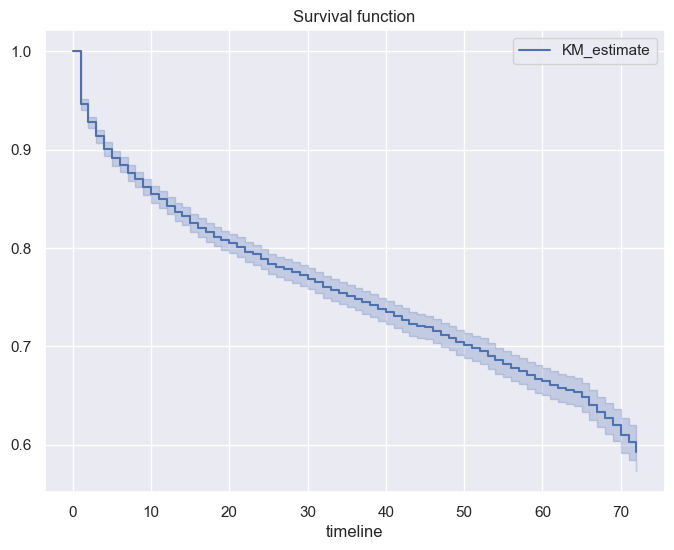

In [123]:
plt.figure(figsize=(8, 6))
km.plot_survival_function()
plt.title('Survival function')
plt.show()

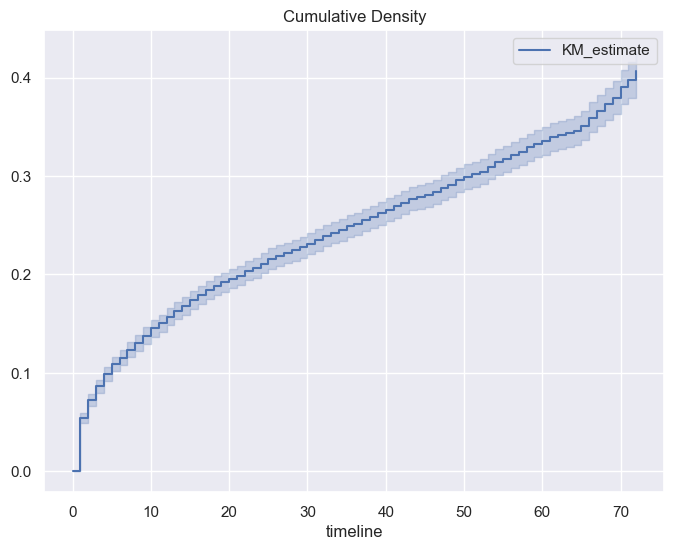

In [124]:
plt.figure(figsize=(8, 6))
km.plot_cumulative_density()
plt.title('Cumulative Density')
plt.show()

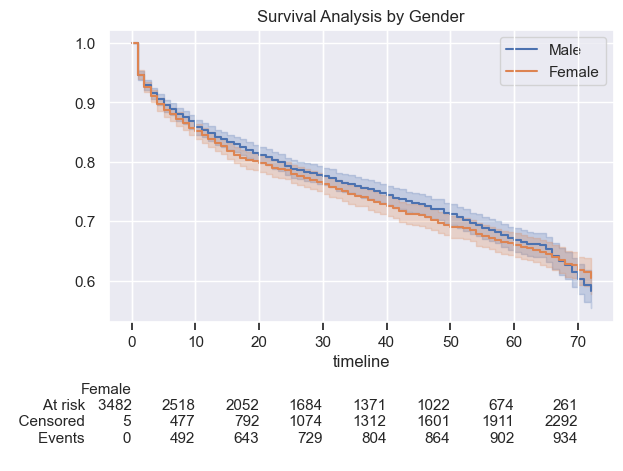

In [125]:
# Survival Analysis by Gender
ax = plt.subplot()
m = (dataset['Gender'] == 0)
km.fit(durations = tenure[m], event_observed = churn[m], label = "Male")
km.plot_survival_function(ax = ax)
km.fit(tenure[~m], event_observed = churn[~m], label = "Female")
km.plot_survival_function(ax = ax, at_risk_counts = True)
plt.title('Survival Analysis by Gender')
plt.show()

In [126]:
#calculating median survival time
median_ = km.median_survival_time_
median_confidence_interval_ = median_survival_times(km.confidence_interval_)
print("Median Survival Time:", median_)
print("Median Confidence Interval:", median_confidence_interval_)

Median Survival Time: inf
Median Confidence Interval:      Female_lower_0.95  Female_upper_0.95
0.5                inf                inf


### Cox Proportional Hazard Model

In [127]:
cox_categorical_columns = [col for col in categorical_columns if col != 'Payment Method']
for i in range(-1, -4, -1):
       cox_categorical_columns.append(list(dataset.columns)[i])

survivaldata = pd.get_dummies(dataset, columns = cox_categorical_columns, drop_first= True)
survivaldata.head()

,Senior Citizen,Tenure,Monthly Charges,Total Charges,Gender_1,Partner_1,Dependents_1,Phone Service_1,Multiple Lines_0,Multiple Lines_1,...,Streaming TV_1,Streaming Movies_0,Streaming Movies_1,Contract_1,Contract_2,Paperless Billing_1,Churn_1,Payment Method(Mailed Check)_1,Payment Method(Electronic Check)_1,Payment Method(Mailed Credit Card)_1
0,0,1,29.85,29.85,1,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,0,1,1,0,...,0,1,0,1,0,0,0,1,0,0
2,0,2,53.85,108.15,0,0,0,1,1,0,...,0,1,0,0,0,1,1,1,0,0
3,0,45,42.30,1840.75,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
4,0,2,70.70,151.65,1,0,0,1,1,0,...,0,1,0,0,0,1,1,0,1,0


In [128]:
value_na = [value for value in dataset.columns if dataset[value].isnull().sum() > 1]

In [129]:
#exploring the entries with null values
dataset[dataset[value_na[0]].isnull()]

,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Monthly Charges,Total Charges,Churn,Payment Method(Mailed Credit Card),Payment Method(Electronic Check),Payment Method(Mailed Check)
488,1,0,1,1,0,0,-1,0,1,0,...,1,0,2,1,52.55,NaN,0,0,0,0
753,0,0,0,1,0,1,0,-1,-1,-1,...,-1,-1,2,0,20.25,NaN,0,0,0,1
936,1,0,1,1,0,1,0,0,1,1,...,1,1,2,0,80.85,NaN,0,0,0,1
1082,0,0,1,1,0,1,1,-1,-1,-1,...,-1,-1,2,0,25.75,NaN,0,0,0,1
1340,1,0,1,1,0,0,-1,0,1,1,...,1,0,2,0,56.05,NaN,0,1,0,0
3331,0,0,1,1,0,1,0,-1,-1,-1,...,-1,-1,2,0,19.85,NaN,0,0,0,1
3826,0,0,1,1,0,1,1,-1,-1,-1,...,-1,-1,2,0,25.35,NaN,0,0,0,1
4380,1,0,1,1,0,1,0,-1,-1,-1,...,-1,-1,2,0,20.00,NaN,0,0,0,1
5218,0,0,1,1,0,1,0,-1,-1,-1,...,-1,-1,1,1,19.70,NaN,0,0,0,1
6670,1,0,1,1,0,1,1,0,0,1,...,1,0,2,0,73.35,NaN,0,0,0,1


In [130]:
#putting all new customers to target for survival analysis
target = dataset[dataset[value_na[0]].isnull()]
target.head()
dataset.dropna(inplace=True)

In [131]:
#defining event and time variable for cox model
eventvar = dataset['Churn']
timevar = dataset['Tenure']

In [132]:
#implementing and fitting cox model
cph = CoxPHFitter()
cph.fit(dataset, duration_col='Tenure', event_col='Churn')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7031 total observations, 5163 right-censored observations>
             duration col = 'Tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7031
number of events observed = 1868
   partial log-likelihood = -12667.17
         time fit was run = 2024-04-30 10:55:18 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
Gender                               0.03       1.04       0.05            -0.06             0.13                 0.94                 1.13
Senior Citizen                       0.03       1.03       0.06            -0.08             0.14                 0.92                 1.15
Partner                             -0.18       0.83       0.06            -0.29            -0.08                 0.75                 0.93
Dependents                          -0.09       0.92       0.07            -0.22             0.05                 0.80                 1.05
Phone Service                        1.12       3.08       0.17             0.78             1.47                 2.19                 4.33
Multiple Lines                       0.20       1.22       0.06             0.08             0.32                 1.09                 1.38
Internet Service                     1.62       5.08       0.14             1.36             1.89                 3.88                 6.64
Online Security                     -0.07       0.93       0.06            -0.19             0.05                 0.83                 1.05
Online Backup                        0.08       1.08       0.05            -0.03             0.18                 0.97                 1.20
Device Protection                    0.23       1.25       0.06             0.12             0.34                 1.12                 1.40
Tech Support                         0.05       1.05       0.06            -0.07             0.18                 0.93                 1.19
Streaming TV                         0.54       1.71       0.08             0.39             0.68                 1.47                 1.98
Streaming Movies                     0.54       1.71       0.08             0.39             0.69                 1.48                 1.99
Contract                            -1.61       0.20       0.08            -1.77            -1.45                 0.17                 0.23
Paperless Billing                    0.15       1.16       0.06             0.04             0.26                 1.04                 1.30
Monthly Charges                     -0.01       0.99       0.01            -0.02            -0.00                 0.98                 1.00
Total Charges                       -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Payment Method(Mailed Credit Card)  -0.01       0.99       0.09            -0.19             0.16                 0.83                 1.18
Payment Method(Electronic Check)     0.39       1.47       0.07             0.24             0.53                 1.28                 1.70
Payment Method(Mailed Check)         0.51       1.66       0.09             0.34             0.68                 1.40                 1.97

                                     cmp to      z      p   -log2(p)
covariate                                                           
Gender                                 0.00   0.74   0.46       1.12
Senior Citizen                         0.00   0.57   0.57       0.82
Partner                                0.00  -3.34 <0.005      10.22
Dependents                             0.00  -1.25   0.21       2.25
Phone Service                          0.00   6.44 <0.005      32.94
Multiple Lines                         0.00   3.34 <0.005      10.22
In

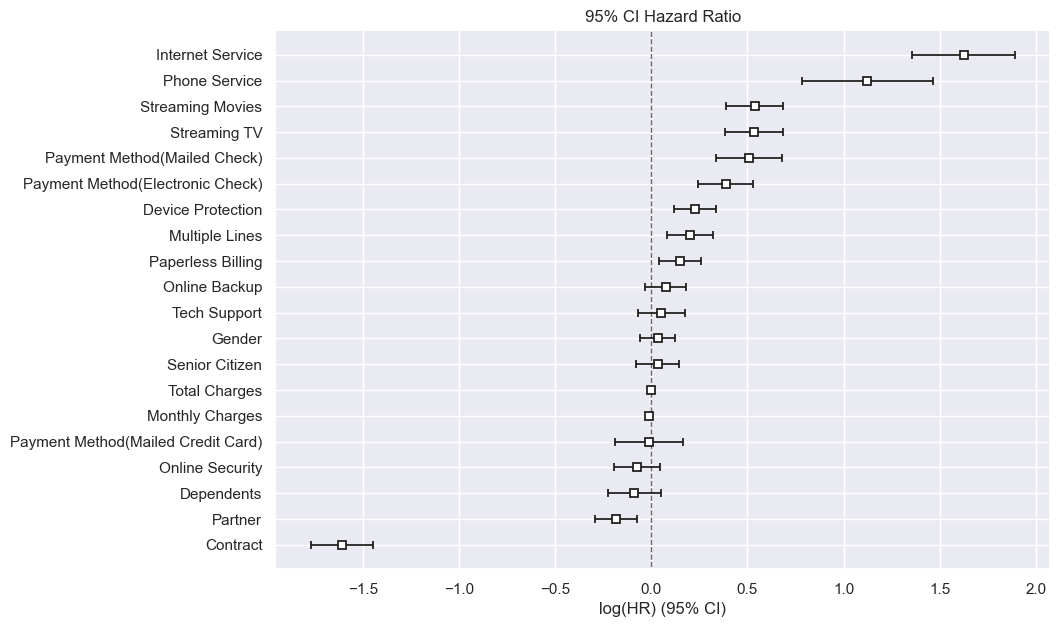

In [133]:
fig, ax = plt.subplots(figsize = (10,7))
cph.plot(ax = ax)
plt.title('95% CI Hazard Ratio')
plt.show()

### Testing Survival Function for Churned Customer

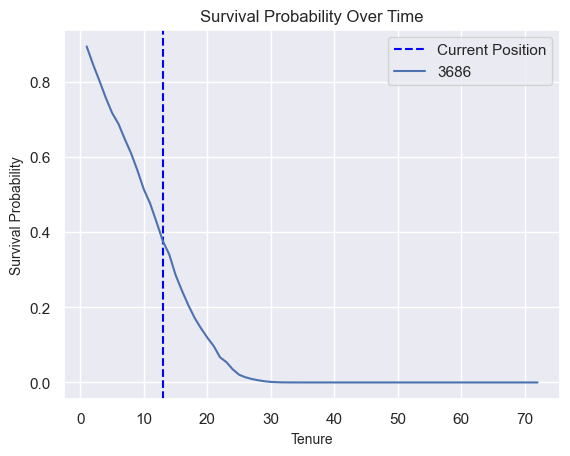

,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Monthly Charges,Total Charges,Churn,Payment Method(Mailed Credit Card),Payment Method(Electronic Check),Payment Method(Mailed Check)
3686,1,0,0,0,13,1,1,1,0,0,...,0,0,0,1,75.0,999.45,1,0,0,1


In [134]:
fig, ax = plt.subplots()
plt.axvline(x=test.iloc[0:11,:].Tenure.values[0], color = 'blue', linestyle='--')
plt.legend(labels=['Current Position'])
cph.predict_survival_function(test.iloc[0:11,:]).plot(ax = ax)
ax.set_xlabel('Tenure', size = 10)
ax.set_ylabel('Survival Probability', size = 10)
ax.set_title('Survival Probability Over Time')
plt.show()
test

### Survival Analysis for Target Customers

In [135]:
target = target.replace(np.nan, 0)

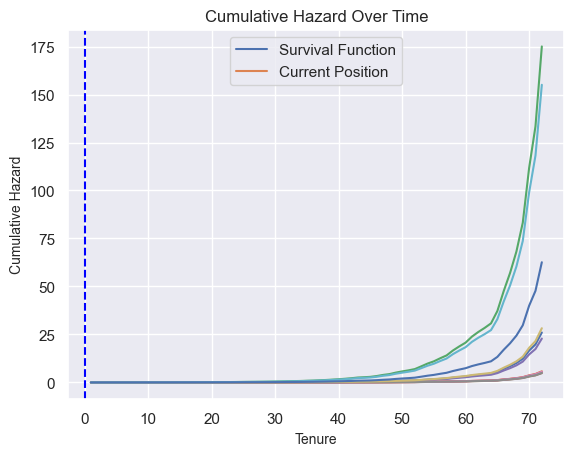

In [136]:
fig, ax = plt.subplots()
cph.predict_cumulative_hazard(target.iloc[0:11,:]).plot(ax = ax)
plt.axvline(x=target.iloc[0:11,:].Tenure.values[0], color = 'blue', linestyle='--')
plt.legend(labels=['Survival Function','Current Position'])
ax.set_xlabel('Tenure', size = 10)
ax.set_ylabel('Cumulative Hazard', size = 10)
ax.set_title('Cumulative Hazard Over Time')
plt.show()

,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Monthly Charges,Total Charges,Churn,Payment Method(Mailed Credit Card),Payment Method(Electronic Check),Payment Method(Mailed Check)
488,1,0,1,1,0,0,-1,0,1,0,...,1,0,2,1,52.55,0.0,0,0,0,0
753,0,0,0,1,0,1,0,-1,-1,-1,...,-1,-1,2,0,20.25,0.0,0,0,0,1
936,1,0,1,1,0,1,0,0,1,1,...,1,1,2,0,80.85,0.0,0,0,0,1
1082,0,0,1,1,0,1,1,-1,-1,-1,...,-1,-1,2,0,25.75,0.0,0,0,0,1
1340,1,0,1,1,0,0,-1,0,1,1,...,1,0,2,0,56.05,0.0,0,1,0,0
3331,0,0,1,1,0,1,0,-1,-1,-1,...,-1,-1,2,0,19.85,0.0,0,0,0,1
3826,0,0,1,1,0,1,1,-1,-1,-1,...,-1,-1,2,0,25.35,0.0,0,0,0,1
4380,1,0,1,1,0,1,0,-1,-1,-1,...,-1,-1,2,0,20.00,0.0,0,0,0,1
5218,0,0,1,1,0,1,0,-1,-1,-1,...,-1,-1,1,1,19.70,0.0,0,0,0,1
6670,1,0,1,1,0,1,1,0,0,1,...,1,0,2,0,73.35,0.0,0,0,0,1


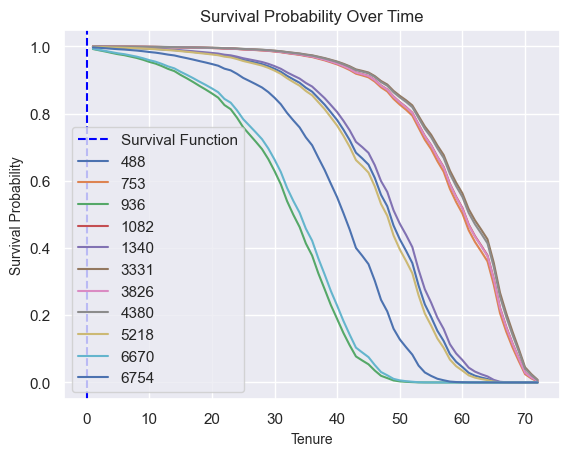

In [137]:
fig, ax = plt.subplots()
plt.axvline(x=target.iloc[0:11,:].Tenure.values[0], color = 'blue', linestyle='--')
plt.legend(labels=['Survival Function','Current Position'])
cph.predict_survival_function(target.iloc[0:11,:]).plot(ax = ax)
ax.set_xlabel('Tenure', size = 10)
ax.set_ylabel('Survival Probability', size = 10)
ax.set_title('Survival Probability Over Time')
target

In [138]:
#loan to value for each target customer
def LTV(info):
    life = cph.predict_survival_function(info).reset_index()
    life.columns = ['Tenure', 'Probability']
    max_life = life.Tenure[life.Probability > 0.1].max()
    
    LTV = max_life * info['Monthly Charges'].values[0]
    return LTV

In [139]:
for customerNo in target.index:
    print(f'LTV of a Customer No. {customerNo} is: {LTV(target.loc[customerNo].to_frame().T):.2f} dollars.')

LTV of a Customer No. 488 is: 2995.35 dollars.
LTV of a Customer No. 753 is: 1377.00 dollars.
LTV of a Customer No. 936 is: 3395.70 dollars.
LTV of a Customer No. 1082 is: 1751.00 dollars.
LTV of a Customer No. 1340 is: 3250.90 dollars.
LTV of a Customer No. 3331 is: 1349.80 dollars.
LTV of a Customer No. 3826 is: 1723.80 dollars.
LTV of a Customer No. 4380 is: 1360.00 dollars.
LTV of a Customer No. 5218 is: 1122.90 dollars.
LTV of a Customer No. 6670 is: 3154.05 dollars.
LTV of a Customer No. 6754 is: 3156.90 dollars.


### Extracting Variables

In [140]:
#independent Variables
X = dataset.drop(columns=['Churn'], axis=1)

#dependent Variable
y = dataset.loc[:, 'Churn']

### Splitting Data

In [141]:
#splitting dataset into trin and test and test size is 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

### Feature Scaling

In [142]:
#standard Scaler will Scale Values between -3 to +3
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

### GridSearchCV (LR, KNS, SVC, GNB, DTC, RFC)

In [143]:
#models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(),
    'GaussianNB': GaussianNB(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier()
}

#model parameters
param_grids = {
    'RandomForestClassifier': {
        'n_estimators': [100, 300, 500],
        'max_depth': [10, 20, 30, None]
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    },
    'LogisticRegression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    'DecisionTreeClassifier': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GaussianNB': {}
}

accuracy_scorer = make_scorer(accuracy_score)
recall_scorer = make_scorer(recall_score)
precision_scorer = make_scorer(precision_score)
roc_auc_scorer = make_scorer(roc_auc_score)

results = []

#grid search with cross validation
for key, value in models.items():
    grid_search = GridSearchCV(estimator=value, param_grid=param_grids[key],cv=10, n_jobs=-1, refit='accuracy', scoring={
    'accuracy': accuracy_scorer,
    'recall': recall_scorer,
    'precision': precision_scorer,
    'roc_auc': roc_auc_scorer
})
    grid_search.fit(X=X_train_scaled, y=y_train)
    print(f'\n{key}')
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_}\n{'-' * 85}")
    metrics_df = pd.DataFrame(grid_search.cv_results_)
    relevant_columns = ['mean_test_precision', 'mean_test_recall', 'mean_test_roc_auc']
    metrics_df = metrics_df[relevant_columns].mean()
    results.append({'Model': key, 'Params': grid_search.best_params_, 'Accuracy': grid_search.best_score_*100, 'Precision': metrics_df['mean_test_precision'], 'Recall': metrics_df['mean_test_recall'], 'ROC AUC': metrics_df['mean_test_roc_auc']})

grid_search_df = pd.DataFrame(results)


LogisticRegression
Best parameters: {'C': 1}
Best cross-validation accuracy: 0.8068949387811861
-------------------------------------------------------------------------------------

KNeighborsClassifier
Best parameters: {'algorithm': 'kd_tree', 'n_neighbors': 9, 'weights': 'uniform'}
Best cross-validation accuracy: 0.7692044398652363
-------------------------------------------------------------------------------------

SVC
Best parameters: {'C': 1, 'gamma': 'scale'}
Best cross-validation accuracy: 0.8040498599900129
-------------------------------------------------------------------------------------

GaussianNB
Best parameters: {}
Best cross-validation accuracy: 0.7338226835142191
-------------------------------------------------------------------------------------

DecisionTreeClassifier
Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best cross-validation accuracy: 0.7684930121426268
----------------------------------------------------------------

### GridSearch Results

In [144]:
best_score = grid_search.best_score_
best_params = grid_search.best_params_
model = grid_search.best_estimator_

print("Best Score:", best_score)
print("Best Parameters:", best_params)
print("Best Model:", model)

Best Score: 0.802455389594382
Best Parameters: {'max_depth': 10, 'n_estimators': 300}
Best Model: RandomForestClassifier(max_depth=10, n_estimators=300)


### Random Forest

In [145]:
#fitting model
model.fit(X_train_scaled, y_train)

#making prediction
y_pred = model.predict(X_test_scaled)

#metrics
model_accuracy = accuracy_score(y_pred=y_pred, y_true=y_test)
model_precision = precision_score(y_pred=y_pred, y_true=y_test)
model_recall = recall_score(y_pred=y_pred, y_true=y_test)
model_cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
model_roc_auc = roc_auc_score(y_score=y_pred, y_true=y_test)
model_fpr, model_tpr, _ = roc_curve(y_score=y_pred, y_true=y_test)
model_accuracy

0.7960199004975125

### XGBoost

In [146]:
#initialising model
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.01,
    max_depth=5,
    random_state=21
)

#fitting model
xgb.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=False)

#making prediction
y_pred = xgb.predict(X_test_scaled)

#metrics
xgb_accuracy = accuracy_score(y_pred=y_pred, y_true=y_test) *100
xgb_precision = precision_score(y_pred=y_pred, y_true=y_test)
xgb_recall = recall_score(y_pred=y_pred, y_true=y_test)
xgb_cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
xgb_roc_auc = roc_auc_score(y_score=y_pred, y_true=y_test)
xgb_fpr, xgb_tpr, _ = roc_curve(y_score=y_pred, y_true=y_test)
xgb_accuracy

77.11442786069652

### Artificial Neural Network

In [147]:
#initialising model
ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#compiling model
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#fitting model
ann.fit(X_train, y_train, epochs=50, batch_size=32)

#making prediction
y_pred = ann.predict(X_test) > 0.5

#metrics
ann_accuracy = accuracy_score(y_pred=y_pred, y_true=y_test) * 100
ann_precision = precision_score(y_pred=y_pred, y_true=y_test)
ann_recall = recall_score(y_pred=y_pred, y_true=y_test)
ann_cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
ann_roc_auc = roc_auc_score(y_score=y_pred, y_true=y_test)
ann_fpr, ann_tpr, _ = roc_curve(y_score=y_pred, y_true=y_test)
ann_accuracy

Epoch 1/50
176/176 [==============================] - 0s 674us/step - loss: 10.1462 - accuracy: 0.7125
Epoch 2/50
176/176 [==============================] - 0s 608us/step - loss: 0.7214 - accuracy: 0.7313
Epoch 3/50
176/176 [==============================] - 0s 604us/step - loss: 0.5810 - accuracy: 0.7468
Epoch 4/50
176/176 [==============================] - 0s 602us/step - loss: 0.5681 - accuracy: 0.7550
Epoch 5/50
176/176 [==============================] - 0s 605us/step - loss: 0.6800 - accuracy: 0.7448
Epoch 6/50
176/176 [==============================] - 0s 610us/step - loss: 0.6210 - accuracy: 0.7457
Epoch 7/50
176/176 [==============================] - 0s 613us/step - loss: 0.7771 - accuracy: 0.7507
Epoch 8/50
176/176 [==============================] - 0s 612us/step - loss: 0.6535 - accuracy: 0.7591
Epoch 9/50
176/176 [==============================] - 0s 811us/step - loss: 0.6082 - accuracy: 0.7681
Epoch 10/50
176/176 [==============================] - 0s 603us/step - loss: 0.63

79.67306325515281

### Metrics Table

In [148]:
results.append({'Model': 'XGBoost', 'Params': '{}', 'Accuracy': xgb_accuracy, 'Precision':xgb_precision, 'Recall': xgb_recall, 'ROC AUC': xgb_roc_auc})
results.append({'Model': 'Artificial Neural Network', 'Params': '{}', 'Accuracy': ann_accuracy,'Precision':ann_precision, 'Recall': ann_recall, 'ROC AUC': ann_roc_auc})
results_df = pd.DataFrame(results)

In [149]:
from tabulate import tabulate
results_df.reset_index(drop=True, inplace=True)
table = tabulate(results_df, headers='keys', tablefmt='psql')
print(table)

+----+---------------------------+------------------------------------------------------------------+------------+-------------+----------+-----------+
|    | Model                     | Params                                                           |   Accuracy |   Precision |   Recall |   ROC AUC |
|----+---------------------------+------------------------------------------------------------------+------------+-------------+----------+-----------|
|  0 | LogisticRegression        | {'C': 1}                                                         |    80.6895 |    0.667154 | 0.490725 |  0.701381 |
|  1 | KNeighborsClassifier      | {'algorithm': 'kd_tree', 'n_neighbors': 9, 'weights': 'uniform'} |    76.9204 |    0.540486 | 0.486609 |  0.669992 |
|  2 | SVC                       | {'C': 1, 'gamma': 'scale'}                                       |    80.405  |    0.650494 | 0.46256  |  0.686677 |
|  3 | GaussianNB                | {}                                                   

### ROC Curve

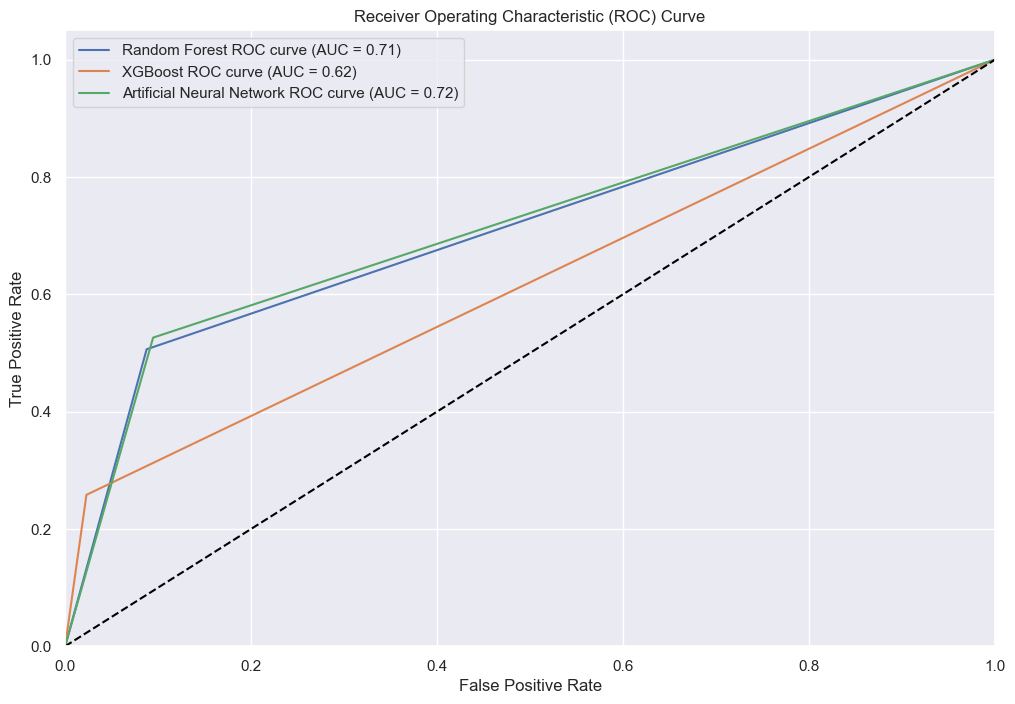

In [154]:
plt.figure(figsize=(12, 8))
plt.plot(model_fpr, model_tpr, label='Random Forest ROC curve (AUC = %0.2f)' % model_roc_auc)
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost ROC curve (AUC = %0.2f)' % xgb_roc_auc)
plt.plot(ann_fpr, ann_tpr, label='Artificial Neural Network ROC curve (AUC = %0.2f)' % ann_roc_auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="best")
#plt.savefig("../Graphs/ROC AUC")
plt.show()

### Confusion Matrix

In [151]:
print('Random Forest \n', model_cm)
print('XGBoost \n', xgb_cm)
print('Artificial Neural Network \n', ann_cm)

Random Forest 
 [[916  88]
 [199 204]]
XGBoost 
 [[981  23]
 [299 104]]
Artificial Neural Network 
 [[909  95]
 [191 212]]


### LIME(Local Interpretable Model-agnostic Explanations)

In [152]:
#initialising explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['No', 'Yes'],
    mode='classification'
)

In [153]:
#plotting explainer for 1 random customer from test set
exp = explainer.explain_instance(
    data_row=X_test.iloc[random.randint(0, len(X_test))], 
    predict_fn=model.predict_proba
)
exp.show_in_notebook(show_table=True)